#**Kermel the frog or Pepe the frog??**

In this section, I will train a baseline model to identify if the provided picture is Kermit or pepe the frog. Then, I will train another two models using transfer learning with only 10% of the images used in the baseline model and compare it using tensorboard

## Required specs

In [36]:
#GENERAL REQUIRED LIBRARIES
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
import os
import pathlib

#VISUAIZE
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

#TENSOR FLOW REQUIREMENTS
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
import tensorflow_hub as hub

#Constants
IMG_SHAPE = (224, 224)

In [2]:
# Library required for downloading images
!pip install simple_image_download

In [3]:
# Library required to split the images folder into train, test set
!pip install split-folders

## Some Functions

### Prepare data

In [17]:
# Methods required for cleaning and eliminating corrupt images
def eliminate_small_images(i, target_folder):
  img = mpimg.imread(target_folder+"/"+i)
  if (img.shape[0]<50):
    os.remove(target_folder+"/"+i)
    return 1
  else:
    return 0

def eliminate_corrupt_images (target_folder):
  """ Eliminate corrupt images and images smaller than 50 in height!
  Args:
    target_folder: The folder where the images were saved after implementing the simp method
  """
  initial_size = len(os.listdir(target_folder))
  counter_corrupt = 0
  small_images = 0
  for i in os.listdir(target_folder):
    try:
      mpimg.imread(target_folder+"/"+i)
    except:
      os.remove(target_folder+"/"+i)
      counter_corrupt +=1
    else:
      small_images += eliminate_small_images(i, target_folder)
  print(f"Number of corrupted images eliminated: {str(counter_corrupt)}")
  print(f"Number of small images eliminated: {str(small_images)}")
  print(f"Total number of images after cleaning: {str(len(os.listdir(target_folder)))}, percentage eliminated: {str(round(100*((counter_corrupt+small_images)/initial_size),2))}%")

In [5]:
# Visualize random Image
def visualize_random_image(target_folder):
  random_image = random.sample(os.listdir(target_folder), 1)
  print(random_image)
  img = mpimg.imread(target_folder+"/"+random_image[0])
  plt.imshow(img)
  plt.axis('off');
  plt.show();

In [6]:
# Requiremes for downloading images
from simple_image_download import simple_image_download as simp
response = simp.simple_image_download
def download_and_clean_images (searchTerm, numberOfImages):
  """ Download and clean all the images based on a search term
  Args:
    seacrhTerm: Term used for searching images in google
    numberOfImages: Number of images fetched 

  Returns:
    Print the number of images eliminated in the passed folder.

  Notes: 
    Create folders with the name of the search term and with corresponding images.
    Images has been cleaned and ready to use
  """
  term = searchTerm
  target_folder = 'simple_images/'+term
  response().download(term, numberOfImages)
  eliminate_corrupt_images(target_folder)
  visualize_random_image(target_folder)

### Data Preparation for training

In [7]:
#Library required for splitting folders
import splitfolders 

def split_and_prepare_images(outPutFolder, trainPerc = 0.7, valPerc = 0.2, testPerc = 0.1):

  splitfolders.ratio('simple_images', output= outPutFolder, seed=1337, ratio = (trainPerc, valPerc, testPerc))
  
  # set the seed
  tf.random.set_seed(42)

  # Preprocess data (get all of the pixel values between 0 and 1)
  train_datagen = ImageDataGenerator(rescale=1./255)
  valid_datagen = ImageDataGenerator(rescale=1./255)
  test_datagen = ImageDataGenerator(rescale=1./255)

  # Set up path to our data directory
  train_dir = outPutFolder + '/train'
  test_dir = outPutFolder +'/test'
  val_dir = outPutFolder +'/val'


  # Import data from directories and turn it into batches
  train_data = train_datagen.flow_from_directory(directory = train_dir,
                                                batch_size = 32,
                                                target_size=(224, 224),
                                                class_mode='binary',
                                                seed=42)
  valid_data = valid_datagen.flow_from_directory(directory = val_dir,
                                                batch_size = 32,
                                                target_size = (224,224),
                                                class_mode = 'binary',
                                                seed = 42)
  test_data = test_datagen.flow_from_directory(directory = test_dir,
                                                batch_size = 32,
                                                target_size = (224,224),
                                                class_mode = 'binary',
                                                seed = 42)
  return train_data, valid_data, test_data

### Model Evaluation

In [20]:
# Plot the validation and training curves separately
def plot_loss_curves(history):
  """
  Return separate loss curves
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.figure()
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss,label = 'val_loss')
  plt.title('loss')
  plt.xlabel('epochs')
  plt.legend()

    # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='accuracy')
  plt.plot(epochs, val_accuracy,label = 'val_accuracy')
  plt.title('accuracy')
  plt.xlabel('epochs')
  plt.legend()

### Function required for trying different hub models

In [50]:
# Let's make create_model() function from URL
def create_model(model_url, num_classes=2):
  """
  Takes a Tf hub and create a Keras sequential model

  Args:
    model_url (str): A tensor flow hub feature extraction.
    num_classes (int): Number of output neurons in the output layers
      should be equal to the number of traget classes

  Returns:
    An uncompiled Keras sequential with model_url as feature extractor
  """
  #Download the model and saved in a keras sequential
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,#Freeze the already learned patterns
                                           name = 'feature_extraction_layer',
                                           input_shape=IMG_SHAPE + (3,)) # Transform it into (224, 224, 3)
  
  model = tf.keras.Sequential([
                               feature_extractor_layer,
                               layers.Dense(1, activation="sigmoid", name="output_layer")
  ])

  return model

## 🏴‍☠️1. Download and clean data

In [9]:
#%rm -rf 'is_will_or_chad'
%rm -rf 'kermit_or_pepe'
#%rm -rf 'simple_images'

Number of corrupted images eliminated: 34
Number of small images eliminated: 21
Total number of images after cleaning: 445, percentage eliminated: 11.0%
['Pepe the frog_485.jpg']


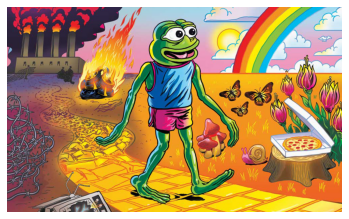

In [9]:
download_and_clean_images('Pepe the frog', 500)

Number of corrupted images eliminated: 28
Number of small images eliminated: 18
Total number of images after cleaning: 454, percentage eliminated: 9.2%
['Kermit the frog_21.jpg']


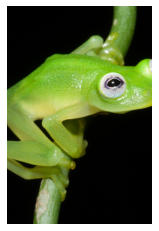

In [10]:
download_and_clean_images('Kermit the frog', 500)

## 🧼2. Data Preparation

In [10]:
# Split the data in train, validation and test sets
train_data, valid_data, test_data = split_and_prepare_images('kermit_or_pepe', 0.7, 0.2, 0.1)

Copying files: 899 files [00:00, 1016.41 files/s]


Found 628 images belonging to 2 classes.
Found 179 images belonging to 2 classes.
Found 92 images belonging to 2 classes.


In [12]:
# Check the number of images in the folder
for dirpath, dirnames, filenames in os.walk('kermit_or_pepe'):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 0 images in 'kermit_or_pepe'.
There are 2 directories and 0 images in 'kermit_or_pepe/val'.
There are 0 directories and 89 images in 'kermit_or_pepe/val/Pepe the frog'.
There are 0 directories and 90 images in 'kermit_or_pepe/val/Kermit the frog'.
There are 2 directories and 0 images in 'kermit_or_pepe/test'.
There are 0 directories and 45 images in 'kermit_or_pepe/test/Pepe the frog'.
There are 0 directories and 47 images in 'kermit_or_pepe/test/Kermit the frog'.
There are 2 directories and 0 images in 'kermit_or_pepe/train'.
There are 0 directories and 311 images in 'kermit_or_pepe/train/Pepe the frog'.
There are 0 directories and 317 images in 'kermit_or_pepe/train/Kermit the frog'.


## 📊3. TensorBoard callback

In [42]:
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f'Saving TensorBoard log file to: {log_dir}')
  return tensorboard_callback

## 🤖4. Baseline Model

In [14]:
# Build a CNN model (Based on the tiny VGG)
baselineModel = tf.keras.models.Sequential([
                                      tf.keras.layers.Conv2D(filters=10,
                                                             kernel_size=3,
                                                             activation='relu',
                                                             input_shape=(224, 224, 3)),
                                      tf.keras.layers.Conv2D(10, 3, activation = 'relu'),
                                      tf.keras.layers.MaxPool2D(pool_size=2,
                                                                padding='valid'),
                                      tf.keras.layers.Conv2D(10, 3, activation = 'relu'),
                                      tf.keras.layers.Conv2D(10, 3, activation = 'relu'),
                                      tf.keras.layers.MaxPool2D(2),
                                      tf.keras.layers.Flatten(),
                                      tf.keras.layers.Dense(1, activation = 'sigmoid')
])

In [15]:
# Compile our CNN
baselineModel.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])


In [16]:
# Fit the model
baselineHistory = baselineModel.fit(train_data, 
                        epochs=5,
                        steps_per_epoch = len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/5
 5/20 [======>.......................] - ETA: 10s - loss: 0.6726 - accuracy: 0.5608

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


20/20 [==============================] - 27s 1s/step - loss: 0.5800 - accuracy: 0.6815 - val_loss: 0.4550 - val_accuracy: 0.8436
Epoch 2/5
20/20 [==============================] - 23s 1s/step - loss: 0.4389 - accuracy: 0.8153 - val_loss: 0.3057 - val_accuracy: 0.8603
Epoch 3/5
20/20 [==============================] - 23s 1s/step - loss: 0.2206 - accuracy: 0.9236 - val_loss: 0.1744 - val_accuracy: 0.9330
Epoch 4/5
20/20 [==============================] - 22s 1s/step - loss: 0.1123 - accuracy: 0.9713 - val_loss: 0.0695 - val_accuracy: 0.9832
Epoch 5/5
20/20 [==============================] - 25s 1s/step - loss: 0.0471 - accuracy: 0.9936 - val_loss: 0.0496 - val_accuracy: 1.0000


### Model Evaluation

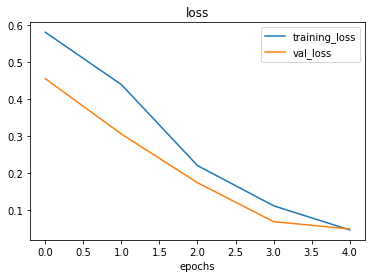

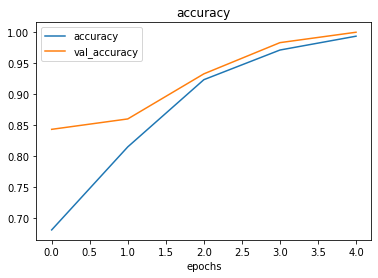

In [21]:
plot_loss_curves(baselineHistory)

In [19]:
baselineModel.evaluate(test_data)

3/3 [==============================] - 3s 974ms/step - loss: 0.0612 - accuracy: 0.9891


[0.06115737184882164, 0.989130437374115]

## 🤯5. Transfer Learning

In [29]:
import tensorflow_hub as hu

### Get only 10% of pictures for training

In [24]:
train_data, valid_data, test_data = split_and_prepare_images('kermit_or_pepe_10%', 0.1, 0.1, 0.8)

Copying files: 899 files [00:00, 919.43 files/s] 


Found 89 images belonging to 2 classes.
Found 89 images belonging to 2 classes.
Found 721 images belonging to 2 classes.


### Copy of the baseline model

In [25]:
baselineClone = tf.keras.models.clone_model(baselineModel)

# Compile our CNN
baselineClone.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [26]:
# Fit the model
baselineCloneHistory = baselineClone.fit(train_data, 
                        epochs=5,
                        steps_per_epoch = len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


3/3 [==============================] - 8s 3s/step - loss: 0.7068 - accuracy: 0.4944 - val_loss: 0.6692 - val_accuracy: 0.6292
Epoch 2/5
3/3 [==============================] - 5s 2s/step - loss: 0.6404 - accuracy: 0.7303 - val_loss: 0.6423 - val_accuracy: 0.5955
Epoch 3/5
3/3 [==============================] - 5s 2s/step - loss: 0.5959 - accuracy: 0.5843 - val_loss: 0.6533 - val_accuracy: 0.4944
Epoch 4/5
3/3 [==============================] - 5s 2s/step - loss: 0.5413 - accuracy: 0.7079 - val_loss: 0.5589 - val_accuracy: 0.7978
Epoch 5/5
3/3 [==============================] - 5s 2s/step - loss: 0.4754 - accuracy: 0.8989 - val_loss: 0.4838 - val_accuracy: 0.7978


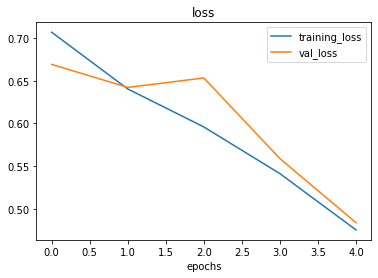

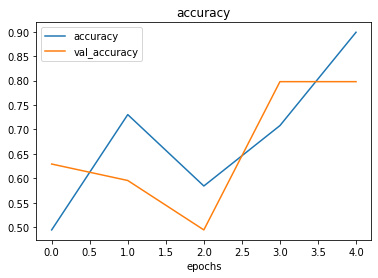

In [27]:
plot_loss_curves(baselineCloneHistory)

**The model is not as accurate when less data is used**

### **Inception_v3**

In [51]:
inception_v3_url = 'https://tfhub.dev/google/tf2-preview/inception_v3/classification/4'

In [52]:
inception_v3_model = create_model(inception_v3_url)

In [53]:
inception_v3_model.compile(loss='binary_crossentropy',
                           optimizer = tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

In [54]:
inception_v3_model_history = inception_v3_model.fit(train_data,
                                              epochs=5,
                                              steps_per_epoch=len(train_data),
                                              validation_data=valid_data,
                                              validation_steps=len(valid_data),
                                              callbacks=[create_tensorboard_callback('tensorflow_hub','inception_v3')])

Saving TensorBoard log file to: tensorflow_hub/inception_v3/20220218-071046
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


3/3 [==============================] - 16s 3s/step - loss: 1.0013 - accuracy: 0.6292 - val_loss: 1.1389 - val_accuracy: 0.5730
Epoch 2/5
3/3 [==============================] - 6s 2s/step - loss: 0.6375 - accuracy: 0.7303 - val_loss: 0.9196 - val_accuracy: 0.6292
Epoch 3/5
3/3 [==============================] - 6s 3s/step - loss: 0.4236 - accuracy: 0.8315 - val_loss: 0.7350 - val_accuracy: 0.7079
Epoch 4/5
3/3 [==============================] - 6s 2s/step - loss: 0.2952 - accuracy: 0.8876 - val_loss: 0.5896 - val_accuracy: 0.7640
Epoch 5/5
3/3 [==============================] - 6s 2s/step - loss: 0.1805 - accuracy: 0.9101 - val_loss: 0.4842 - val_accuracy: 0.7978


### **Efficientnet_B0**

In [55]:
efficient_net_b0_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/classification/1'

In [56]:
efficient_net_b0_model = create_model(efficient_net_b0_url)

In [57]:
efficient_net_b0_model.compile(loss='binary_crossentropy',
                           optimizer = tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

In [58]:
efficient_net_b0_model_history = efficient_net_b0_model.fit(train_data,
                                              epochs=5,
                                              steps_per_epoch=len(train_data),
                                              validation_data=valid_data,
                                              validation_steps=len(valid_data),
                                              callbacks=[create_tensorboard_callback('tensorflow_hub','efficient_net_b0')])

Saving TensorBoard log file to: tensorflow_hub/efficient_net_b0/20220218-071454
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


3/3 [==============================] - 21s 3s/step - loss: 0.6981 - accuracy: 0.3371 - val_loss: 0.6971 - val_accuracy: 0.3034
Epoch 2/5
3/3 [==============================] - 8s 3s/step - loss: 0.6972 - accuracy: 0.3483 - val_loss: 0.6964 - val_accuracy: 0.3146
Epoch 3/5
3/3 [==============================] - 6s 2s/step - loss: 0.6963 - accuracy: 0.3708 - val_loss: 0.6957 - val_accuracy: 0.3820
Epoch 4/5
3/3 [==============================] - 6s 2s/step - loss: 0.6955 - accuracy: 0.4270 - val_loss: 0.6950 - val_accuracy: 0.4270
Epoch 5/5
3/3 [==============================] - 8s 3s/step - loss: 0.6946 - accuracy: 0.4719 - val_loss: 0.6944 - val_accuracy: 0.4719


##🕵🏻 6. Upload and check in Tensor Board

In [59]:
!tensorboard dev upload --logdir ./tensorflow_hub/\
  --name "Kermit or pepe model"\
  --description "Comparing three models with only 10% of the data: baseline vs inception_v3 vs. efficient_net_b0"\
  --one_shot #close the uploading


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=9wiACiSvk9bc7SRYFuQtunPVmEmbNt&prompt=consent&access_type=off